In this notebook we will fit a sinusoidal component to the residuals. Recall the residuals are the de-trended CO$_2$ data obtained by subtracting from $y_i$ the quadratic fit, that is $r_i=y_i−f(x_i)$, and $f(x_i)=\beta_0 + \beta_1 x_i + \beta_2 x_i^2$ for $i=0,1, \ldots, N−1$. 


Let us load the CO$_2$ dataset we used in Notebook 1.

In [1]:
# If you are running this on Google Colab, uncomment and run the following lines; otherwise ignore this cell
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

CO2_data_full =  np.load('Data/CO2_data_full.npy')
# If you are running on Google Colab, change the path to '/content/drive/MyDrive/IB-Data-Science/Data/CO2_data_full.npy'

dates = CO2_data_full[:,0]
CO2_levels = CO2_data_full[:,1]

Let us recall the quadratic model we fit in Notebook 1, and plot the residuals.

The least squares coefficients are:
 beta_0 =  47931.753 	 beta_1 =  -49.411 	 beta_2 =  0.013


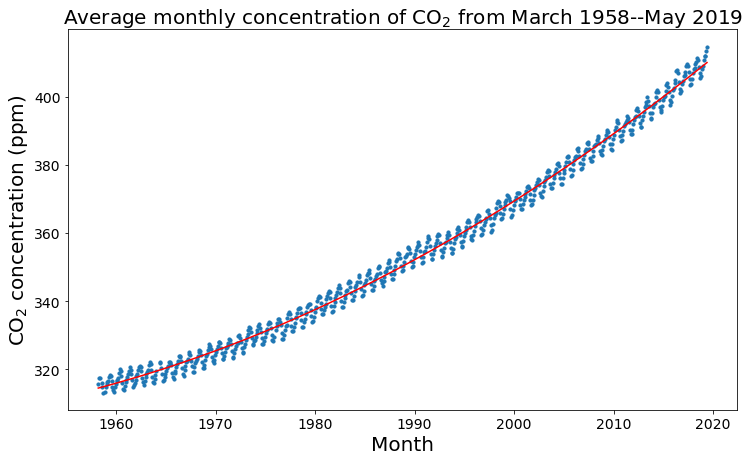

In [3]:
# Fitting a quadratic model

# Create a matrix X with the first column all ones, second column containing dates, and the third col. 
# containing square of dates
all_ones = np.ones(np.shape(dates))
X = np.column_stack((all_ones, dates, dates**2))
XT= X.T 
yvalues = CO2_levels

beta_quad = np.linalg.inv(XT.dot(X)).dot(XT).dot(yvalues) # Calculating the least-squares coefficients
print('The least squares coefficients are:\n beta_0 = ', np.round(beta_quad[0], 3), 
      '\t beta_1 = ', np.round(beta_quad[1], 3), '\t beta_2 = ', np.round(beta_quad[2], 3) )
fit_quad = X.dot(beta_quad)

# to make sure figures are large enough for interpretation, you can try changing these values
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Scatter plot and quadratic fit
plt.scatter(dates, CO2_levels, s=10)
plt.plot(dates, fit_quad, 'r')
plt.xlabel('Month')
plt.ylabel('CO$_2$ concentration (ppm)')
plt.title('Average monthly concentration of CO$_2$ from March 1958--May 2019')
plt.show()

Let us plot the residuals and zoom in to small range to see the periodic variations.

Mean of residuals 0.0
Sum of squared errors SSE for quadratic model is: 3584.063
Mean squared error MSE for quadratic model is: 4.923


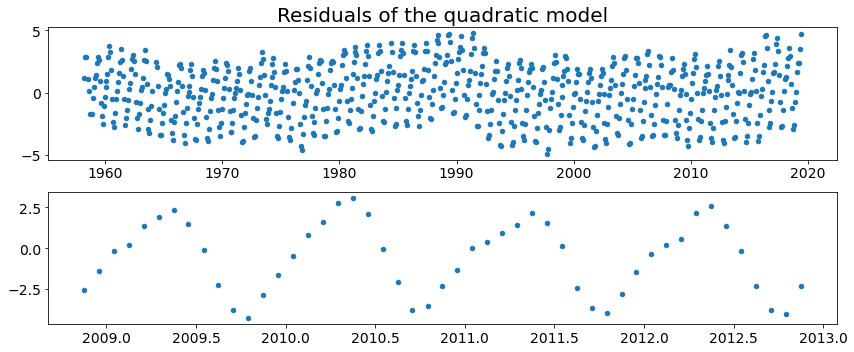

In [4]:
resid_quad = yvalues - fit_quad
SSE_quad = np.linalg.norm(resid_quad)**2
MSE_quad = SSE_quad/np.size(yvalues)
print('Mean of residuals', np.round(np.mean(resid_quad),3))
print('Sum of squared errors SSE for quadratic model is:', np.round(SSE_quad,3))
print('Mean squared error MSE for quadratic model is:', np.round(MSE_quad,3))

plt.rcParams['figure.figsize'] = [12, 5]
plt.subplot(211)
plt.scatter(dates, resid_quad, s=20)
plt.title('Residuals of the quadratic model')
plt.subplot(212)
plt.scatter(dates[601:650], resid_quad[601:650], s=20) 
plt.tight_layout()
plt.savefig('residuals_CO2.pdf', bbox_inches = 'tight')

## Identifying the periodic components using the Discrete Fourier Transform

The residuals plotted above were obtained after fitting a model to capture the trend, so they are often called the _de-trended_ residuals. We can capture the periodic component in the de-trended residuals by fitting sinusoids of appropriate frequencies.  

From a visual inspection of the zoomed-in residuals, we see that there appears to be a periodicity of around one year. This suggests fitting a sinusoidal function of the form
$$
f(x_i) = A \sin\Big( \frac{2 \pi}{T} x_i + \phi \Big), \qquad i=1, \ldots, N.
$$

If we know the period $T$, we can use least squares to find the amplitude $A$ and phase shift $\phi$. To fully automate the fitting process, we will use the Discrete Fourier Transform (DFT) to determine the period $T$.

For a discrete-time sequence $[g_0, \ldots, g_{N-1}]$, recall that the $N$-point DFT is a sequence $[G_0, \ldots, G_{N-1}]$ given by

$$
G_k =\sum_{n=0}^{N-1} g_n \, e^{-{\rm{j}} 2 \pi n k/N}, \qquad k=0, \ldots, (N-1).
$$

The discrete-time sequence can be recovered from the DFT coefficients as 

$$
g_n = \frac{1}{N} \sum_{k=0}^{N-1}\ G_k \, e^{{\rm{j}} 2 \pi  n k/N}, \qquad n=0, \ldots, (N-1).
$$


Recall the following fact from IB Paper 6 Signal and Data Analysis (Handout 6): If the time interval between adjacent samples in the discrete-time signal is $T$ seconds, (i.e., $g_n = g(nT)$ for $n=0, \ldots, N-1$), then the $N$-point DFT of the signal gives the frequency components at $N$ equally-spaced multiples of $2 \pi/T$ rad/s. That is, the $N$ DFT coefficients correspond to frequencies

\begin{equation}
0, \ \frac{2\pi}{T} \frac{1}{N}, \  \frac{2\pi}{T}\frac{2}{N}, \ \ldots, \ \frac{2\pi}{T}\frac{(N-1)}{N}  \text{ rad/sec}
\end{equation}

In our case, $T$ is measured in units of years. Therefore $| G_k |^2$ gives the strength of the frequency component at $\frac{2 \pi}{T} \frac{k}{N}$ rad/year, for $k=0, \ldots, (N-1)$.

The squared magnitudes of the DFT coefficients is sometimes called the _periodogram_. Let us compute the DFT coefficients  of the residual (using the `np.fft.fft` command), and plot the periodogram to identify the dominant frequencies. 

C:\Users\Eduar\AppData\Local\Temp\ipykernel_34784\2503107999.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('DFT_CO2.pdf', bbox_layout = 'tight')


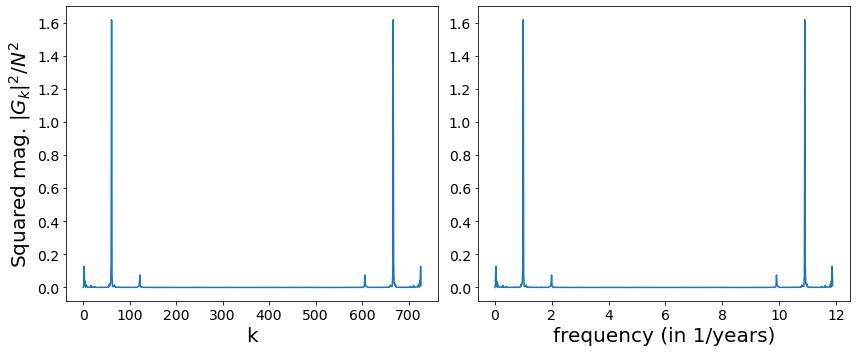

In [6]:
N = np.size(dates)
T = dates[501] - dates[500]  # This can be the time interval between any two successive values.

# Note that T is in years

# Compute the squared magnitudes of the DFT coefficients -- this is known as the "periodogram"
pgram = np.abs(np.fft.fft(resid_quad, N)/N)**2 #We normalize by N, but this is optional
indices = np.linspace(0, (N-1), num = N)
freqs_in_hz = indices/(N*T)
freqs_in_rads = freqs_in_hz*2*math.pi

plt.subplot(121)
plt.plot(indices, pgram)
plt.xlabel('k')
plt.ylabel('Squared mag. $|G_k|^2/N^2$')
plt.subplot(122)
plt.plot(freqs_in_hz, pgram)
plt.xlabel('frequency (in 1/years)')  # Since units of T is years
plt.savefig('DFT_CO2.pdf', bbox_layout = 'tight')
plt.tight_layout()

Observe that the plots are symmetric around the middle of the x-axis. This is because for a real-valued sequence $g_n$, the DFT coefficients $G_k$ satisfy

\begin{equation}
G_k = G^*_{N-k}, \qquad 0 \leq k \leq (N-1).
\end{equation}

(Try to verify this using the formula for $G_k$ above, or see Signal and Data Analysis, Examples Paper 7, Q.6). 

Therefore $|G_k|^2 = |G_{N-k}|^2$, hence the symmetry.

The dominant frequency component corresponds to a period of around 1 year, which is consistent with a rough visual inspection of the periodicity  of the residuals above. Let us now pick out the frequency components in the periodogram that exceed 20% of the maximum value in the periodogram. 

In [10]:
top_inds = indices[(pgram > 0.2*np.max(pgram))]
top_freqs_hz = freqs_in_hz[(pgram > 0.2*np.max(pgram))]
print('Top indices:', top_inds, ' Top frequencies in Hz:', top_freqs_hz)
assert top_inds.sum()==N

Top indices: [ 61. 667.]  Top frequencies in Hz: [ 0.99751439 10.90724751]


The top indices are $k^* = 61$ and $N-k^*=667$.  We now fit a sinusoid to the sequence of residuals with the frequency corresponding to $k^*$ to capture the  periodic behavior of the residual sequence. This is a function of the form

\begin{align}
A \, \sin\Big( \frac{2\pi k^*}{NT} x \, + \, \varphi \Big) =  A \cos(\varphi) \, \sin\Big( \frac{2\pi k^*}{NT}x \big) \,  + \,  A \sin(\varphi) \, \cos\Big( \frac{2\pi k^*}{NT}x \Big)
\end{align}

The $x$-values (times) in the time-series are of the form $x_n = x_0 +  nT$, for $n=0, \ldots, (N-1)$, where $x_0$ is the initial date and $T$ is the time interval between adjacent samples.

In general, we can consider a function of the form $$r(x) =  \beta_s \, \sin\Big( \frac{2\pi k^*}{NT}x \big) + \beta_c \cos\Big( \frac{2\pi k^*}{NT}x \big),$$ 

and determine the optimal coefficients $\beta_s, \beta_c$ via least-squares (linear regression). A couple of things to note:

1. In this case, we do not need a constant $\beta_0$ in $f(x)$ as the residuals have zero mean. Another way to think about it is that the constant term has already been taken care of by the linear/quadratic fit.
    
2. We also do not need to separately consider the frequency corresponding to the index $(N-k^*)$ because

\begin{align}
\sin\Big( \frac{2\pi (N-k^*)}{NT} nT \big) = - \sin\Big( \frac{2\pi k^*}{NT} nT \big), \qquad 
\cos\Big( \frac{2\pi (N-k^*)}{NT} nT \Big) = \cos\Big( \frac{2\pi k^*}{NT} nT \Big), \quad 0 \leq n \leq (N-1).
\end{align}

 It is therefore sufficient to include the frequency corresponding to index $k^*$.
   



The coefficients beta_s, beta_c are: [ 2.05469129 -1.73314629]


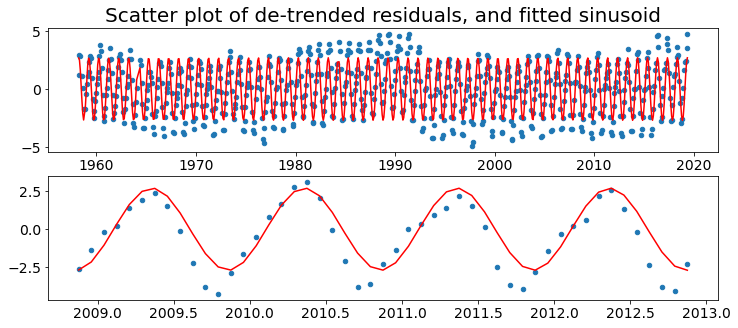

In [11]:
w = 2*math.pi*top_inds[0]/(N*T)  # Freq. in rad/s corresponding to k* is w = 2.pi.k*/(NT)

# Now form the X matrix with columns sin(wx) and cos(wx) for x in dates. First define its transpose
XT = np.vstack((np.sin(w*dates), np.cos(w*dates)))
X = np.transpose(XT)

beta_sc = np.linalg.inv(XT.dot(X)).dot(XT).dot(resid_quad) # Calculating the least-squares coefficients
print('The coefficients beta_s, beta_c are:', beta_sc)
fit_sc = X.dot(beta_sc)

plt.subplot(211)
plt.scatter(dates, resid_quad, s=20)
plt.plot(dates, fit_sc, 'r')
plt.title('Scatter plot of de-trended residuals, and fitted sinusoid')
# Zoom in to a few values
plt.subplot(212)
plt.scatter(dates[601:650], resid_quad[601:650], s=20)
plt.plot(dates[601:650], fit_sc[601:650], 'r')

plt.show()

The coefficients are: my_beta_s = 2.055, my_beta_c = -1.72858


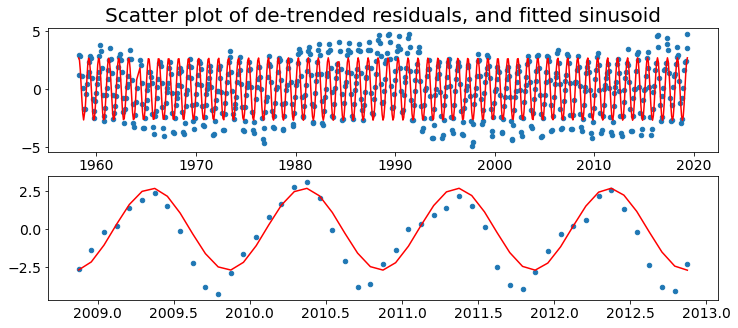

In [20]:
# O(N) solution
my_beta_s = (resid_quad * np.sin(w * dates)).sum() * 2/ N
my_beta_c = (resid_quad * np.cos(w * dates)).sum() * 2/ N
print(f'The coefficients are: my_beta_s = {round(my_beta_s,5)}, my_beta_c = {round(my_beta_c ,5)}')

my_fit_sc = my_beta_s * np.sin(w * dates) + my_beta_c * np.cos(w * dates)

plt.subplot(211)
plt.scatter(dates, resid_quad, s=20)
plt.plot(dates, my_fit_sc, 'r')
plt.title('Scatter plot of de-trended residuals, and fitted sinusoid')
# Zoom in to a few values
plt.subplot(212)
plt.scatter(dates[601:650], resid_quad[601:650], s=20)
plt.plot(dates[601:650], my_fit_sc[601:650], 'r')

plt.show()

Let us compute and plot the final residuals, and examine their distribution.

In [14]:
resid_final = resid_quad - fit_sc
SSE_final = np.linalg.norm(resid_final)**2
MSE_final = SSE_final/np.size(yvalues)
print('Mean of final residuals:', np.round(np.mean(resid_final), 3))
print('Sum of squared errors SSE for quadratic + sinusoid model is:', np.round(SSE_final, 3)) 
print('Mean squared error MSE for quadratic + sinusoid model is:',  np.round(MSE_final,3))

Mean of final residuals: 0.005
Sum of squared errors SSE for quadratic + sinusoid model is: 956.609
Mean squared error MSE for quadratic + sinusoid model is: 1.314


We observe the SSE/MSE for the combined quadratic + sinusoid model is smaller than that of the plain quadratic model, by a factor of around 3.5. Let us plot the distribution of the final residuals. 

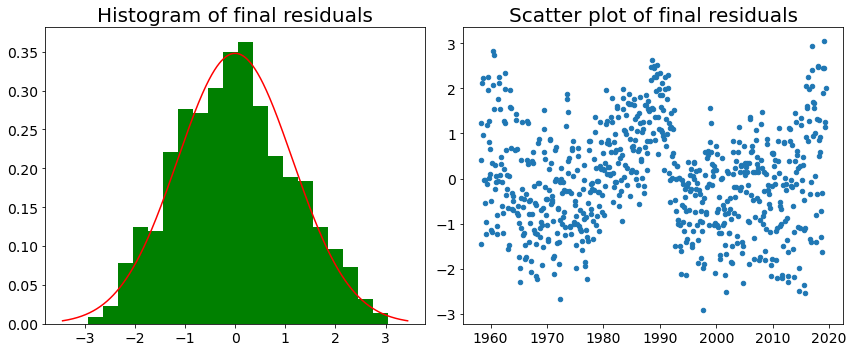

In [15]:
# Plot normed histogram of the residuals

from scipy.stats import norm

# Plot Gaussian pdf with same mean and variance as the residuals
res_final_stdev = np.std(resid_final)  #standard deviation of residuals
xvals = np.linspace(-3*res_final_stdev,3*res_final_stdev,1000)
plt.subplot(121)
n, bins, patches = plt.hist(resid_final, bins=20, density=True, facecolor='green');
plt.plot(xvals, norm.pdf(xvals, loc=0, scale=res_final_stdev), 'r')
plt.title('Histogram of final residuals')
plt.subplot(122)
plt.scatter(dates, resid_final, s=20)
plt.title('Scatter plot of final residuals')
plt.tight_layout()

The final residuals are reasonably well-approximated by a Gaussian. There appears to be a bit of long-term periodicity in the final residuals (with a period of ~30 years) -- we suspect that this is the one indicated by the small peak on the DFT plot at $k=2$. Let us check by computing the DFT of the final residuals.

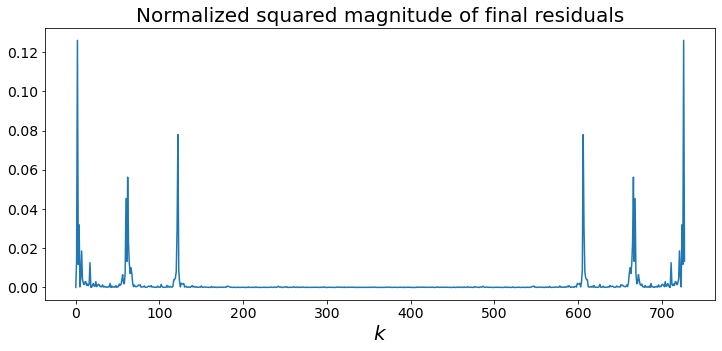

In [16]:
# Compute the squared magnitudes of the DFT coefficients of the final residuals
pgram2 = np.abs(np.fft.fft(resid_final, N)/N)**2 
plt.plot(indices, pgram2)
plt.xlabel('$k$')
plt.title('Normalized squared magnitude of final residuals')
plt.show()

In [17]:
# Pick out the top indices --  say, ones that exceed 50% of the maximum
top_inds2 = indices[(pgram2 > 0.5*np.amax(pgram2))]
print('Top indices:', top_inds2)

Top indices: [  2. 122. 606. 726.]


**Should we fit more sinusoids?**
One could fit a more complicated model by including  sinusoids corresponding to these indices as well.  However, we choose not to do this because the largest squared magnitude in the DFT of the final residual (~0.12) is much smaller than the one for the frequency we fit -- recall that the squared magnitude of the DFT coefficient at $k^*=61$ was ~1.6)

Given a dataset, how complicated a model we should fit is an important--but somewhat subjective--question. The goal is to fit a model that gives good prediction on _new_ data, i.e., data that have _not_ been used to determine the fit. So we often prefer a simpler model to a more complicated one, if their SSE/MSE performance is similar. For more on this, see the notebook on [Model Selection](03%20Model%20Selection%20[Optional].ipynb).

## The combined fit

We have fit a model of the form $f(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_s \sin(\omega x) + \beta_c \cos( \omega x)$, where $f(x)$ is the predicted CO$_2$ level for date $x$ (expressed in decimal year). The coefficients of the model, which we computed using least squares, are:

In [22]:
print('beta_0 = ', np.round(beta_quad[0], 3), '\t beta_1 = ', np.round(beta_quad[1], 3), '\t beta_2 = ', 
      np.round(beta_quad[2], 3) )
print('beta_s = ', np.round(beta_sc[0], 3), '\t beta_c = ', np.round(beta_sc[1], 3))

beta_0 =  47931.753 	 beta_1 =  -49.411 	 beta_2 =  0.013
beta_s =  2.055 	 beta_c =  -1.733


The frequency for the sinusoidal part is $\omega =  \frac{2 \pi k^*}{NT}$ rad/s, where $k^*$ was identified via Fourier analysis of the quadratic residuals:

In [23]:
print('ω = ', np.round(w, 3), 'rad/year')

ω =  6.268 rad/year


Let us now plot the data alongside the combined fit.

C:\Users\Eduar\AppData\Local\Temp\ipykernel_34784\2296237081.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('CO2_combined_fit.pdf', bbox_layout = 'tight')


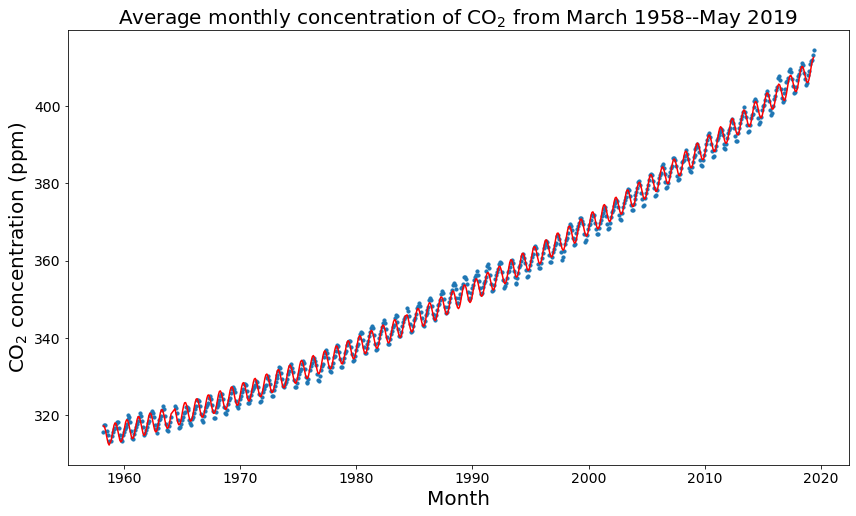

Sum of squared errors for the combined fit =  956.609
Mean squared error for the combined fit =  1.314
R^2 coefficient of combined fit =  0.998


In [24]:
fit_combined = fit_quad + fit_sc
#resid_comb = yvalues - fit_combined # This will is the same as resid_final computed above

plt.rcParams['figure.figsize'] = [14, 8]


plt.scatter(dates, CO2_levels, s=10)
plt.plot(dates, fit_combined, 'r')
plt.xlabel('Month')
plt.ylabel('CO$_2$ concentration (ppm)')
plt.title('Average monthly concentration of CO$_2$ from March 1958--May 2019')
plt.savefig('CO2_combined_fit.pdf', bbox_layout = 'tight')
plt.show()

print('Sum of squared errors for the combined fit = ', np.round(SSE_final,3))
print('Mean squared error for the combined fit = ', np.round(MSE_final,3))

SSE_0 = np.linalg.norm(yvalues - np.mean(yvalues))**2
R2_combined = 1 - SSE_final/SSE_0
print('R^2 coefficient of combined fit = ', np.round(R2_combined, 3))

## Summary

   1. A time series can usually be modelled as the sum of a trend, a seasonal (periodic) component, and noise. 
   1. We first fit a model to capture the trend -- we used a quadratic model in our example. The residuals corresponding to this model are a de-trended time series containing the periodic components. 
   1. The domninant frequencies in the periodic component can be identified using the DFT. We fit sinusoids corresponding to the dominant frequencies using least squares. 
   1. As should be clear by now, least squares (linear regression) is a valuable tool for fitting models to datasets.   
   1. How complicated a model one should fit is an important issue. For instance, should we use a linear or quadratic model for the trend? How many sinusoidal components should we use for the periodic component?  A good rule of thumb is: "A simpler model that explains the data reasonably well is  better than a complicated model that only does slightly better." For more discussion on this with examples, see the notebook on  [Model Selection](03%20Model%20Selection%20[Optional].ipynb).

## Reference

1. _Time Series Analysis and its Applications_ , R. H. Shumway and D. S. Stoffer, 4th edition, 2017. Free downloadable copy available [here](https://www.stat.pitt.edu/stoffer/tsa4/).  (Chapter 4 describes the use of the periodogram to identify periodic components in a time series.)

## You should now complete [Exercise notebook 3](Exercises/)